# Fires widgets

This widget takes an Area of Interest (adm0, adm1, adm2) and requests the number of fires recorded in the last X number of days. The service is only able to look back as far as the last 7 days, however.

The widget should simply display a dynamic sentence showing the number of detected fires in the AOI over the last X number of days.

**NOTE**: The service is a little spotty and sometimes needs a few attempts to return a value

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
from datetime import date
from datetime import timedelta
import datetime
import math


In [12]:
adm0 = 'BRA'
adm1 = None
adm2 = None


time_frame = 7 #interested in the last 7 days
threshold = 0  #hardcode this

tags = ["forest_change"]
selectable_polynames = [None]

#metadata slug: widget_fire_alert_location

# Functions

In [13]:
def get_geostore(iso, adm1=None, adm2=None):
    """Returns geostore of adm region. Here, it is only required for adm2 since
    the VIIRS service only has endpoints for adm0 and adm1 regions"""
   
    if adm2:
        print('Request for adm2 area')
        url =f'https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}/{adm2}' 
    elif adm1:
        print('Request for adm1 area')
        url =f'https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}' 
    elif iso:
        print('Request for adm0 area')
        url =f'https://api.resourcewatch.org/v1/geostore/admin/{iso}'
    
    r = requests.get(url)
    data = r.json().get('data').get('id')
    
    return data

In [14]:
def fires_queries(start_date, end_date, iso, adm1=None, adm2=None):
    """Returns the ncorrect url and params for the VIIRS query. Adm2 requires a geostore
    as the VIIRS service only has endpoints for adm0 and adm1 regions"""
    
    if adm2:
        url = f'https://production-api.globalforestwatch.org/v1/viirs-active-fires'
        properties = {
              "geostore" : get_geostore(iso, adm1, adm2),
              "period" : start_date + ',' + end_date,
              "thresh" : threshold,
              "group" : 'true'}
    elif adm1:
        url = f'https://production-api.globalforestwatch.org/v1/viirs-active-fires/admin/{iso}/{adm1}'   
        properties = {
              "period" : start_date + ',' + end_date,
              "thresh" : threshold,
              "group" : 'true'}
    elif iso:
        url = f'https://production-api.globalforestwatch.org/v1/viirs-active-fires/admin/{iso}'
        properties = {
              "period" : start_date + ',' + end_date,
              "thresh" : threshold,
              "group" : 'true'}
    
    return (url, properties)

In [15]:
def time_period(time_frame=7):
    """Returns a start- and end-date to be passed to query in 'yyyy-mm-dd' format
    where the start date is the current date (today). Defaults to the last week (days=7)"""
    
    today = date.today()
    
    start = today.strftime('%Y-%m-%d')
    end = (today - timedelta(days=time_frame-1)).strftime('%Y-%m-%d') 
    
    return (start, end)

In [16]:
%%time

#Get start and end dates
start_date = time_period(time_frame)[1]
end_date = time_period(time_frame)[0]

#Get url and params for requests
url = fires_queries(start_date, end_date, adm0, adm1, adm2)[0]
params = fires_queries(start_date, end_date, adm0, adm1, adm2)[1]

r = requests.get(url, params)

print(r.url)
print(f'Status: {r.status_code}')

data = r.json().get('data')

pprint(data)

https://production-api.globalforestwatch.org/v1/viirs-active-fires/admin/BRA?group=true&period=2018-01-26%2C2018-02-01&thresh=0
Status: 200
[{'attributes': {'day': '2018-01-27T00:00:00Z', 'value': 281},
  'id': 'undefined',
  'type': 'viirs-fires'},
 {'attributes': {'day': '2018-01-31T00:00:00Z', 'value': 252},
  'id': 'undefined',
  'type': 'viirs-fires'},
 {'attributes': {'day': '2018-01-29T00:00:00Z', 'value': 269},
  'id': 'undefined',
  'type': 'viirs-fires'},
 {'attributes': {'day': '2018-01-30T00:00:00Z', 'value': 618},
  'id': 'undefined',
  'type': 'viirs-fires'},
 {'attributes': {'day': '2018-01-28T00:00:00Z', 'value': 276},
  'id': 'undefined',
  'type': 'viirs-fires'},
 {'attributes': {'day': '2018-01-26T00:00:00Z', 'value': 232},
  'id': 'undefined',
  'type': 'viirs-fires'}]
CPU times: user 7.62 ms, sys: 5.16 ms, total: 12.8 ms
Wall time: 14.9 ms


In [17]:
#Extract data and ensure it is in correct order
#Also calculate the total number of fires.

counts = []
total_fires = 0

if adm2:
    total_fires = data.get('attributes').get('value')

else:
    for d in data:
        if d.get('attributes').get('day'):
            counts.append({'count': d.get('attributes').get('value'), 'date': d.get('attributes').get('day')[:10]})
            total_fires += d.get('attributes').get('value')

            #Order list by 'date'
            counts = sorted(counts, key=lambda k: k['date'], reverse=True)

            counts

# Graph

Shows a sparkline representing the number of fires detected in each day over the previous 7 day period.

ONLY FOR ADM0

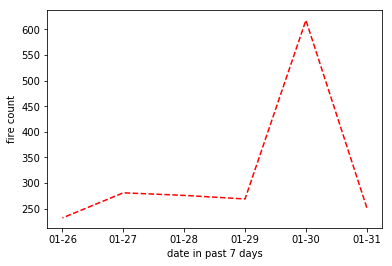

In [18]:
x_data = []
y_data = []

for c in counts:
    y_data.append(c.get('count'))
    x_data.append(c.get('date')[5:10])

plt.plot(x_data, y_data, 'r--')

ax = plt.gca()

ax.set_xlabel('date in past 7 days')
ax.set_ylabel('fire count')

plt.show()

In [19]:
areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name')

In [20]:
if adm2:
    print(f"In {areaId_to_name[adm2]} ", end="")
elif adm1: 
    print(f"In {areaId_to_name[adm1]} ", end="")
elif adm0:
    print(f"In {iso_to_countries[adm0]} ", end="")

# Say 'no fires' instead of '0 fires'
if counts == 0:
    counts = 'no'
    
print(f"there were {total_fires} active fires detected in the last 7 days.", end="")

In Brazil there were 1928 active fires detected in the last 7 days.